In [1]:
from pyspark.sql.functions import udf, col, explode, trim
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql import SparkSession
import spacy

In [2]:
spark = SparkSession.builder \
    .appName("Noun Phrase Extraction") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/06 09:40:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
text_df = spark.read.text("./data/task2/paul_articles/*.txt").filter(col("value") != '')
text_df.show(5, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                      

In [ ]:
# !python -m spacy download en_core_web_sm

In [5]:
nlp = spacy.load("en_core_web_sm")

def extract_noun_phrases(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks if chunk[0].pos_ == 'NOUN']

extract_noun_phrases_udf = udf(extract_noun_phrases, ArrayType(StringType()))
noun_phrases_df = text_df.select(explode(extract_noun_phrases_udf("value")).alias("noun_phrases"))
noun_phrases_df = noun_phrases_df.filter(~trim(col("noun_phrases")).rlike("^\\S+$"))
noun_phrases_df = noun_phrases_df.filter(~(col("noun_phrases").rlike(r'\b(?:a|the|an|one|this|that|your|their)\b')))

# noun_phrases_df.show(5, truncate = False)
# noun_phrase_freq = noun_phrases_df.groupBy("noun_phrases").count().orderBy("count", ascending=False)
# noun_phrase_freq.show(5, truncate=False)

In [6]:
noun_phrases_df.show(5, truncate = False)


+------------------------+
|noun_phrases            |
+------------------------+
|beginning writers       |
|disk drives             |
|card reader             |
|punch cards             |
|calculate approximations|
+------------------------+
only showing top 5 rows



In [7]:
noun_phrases_df.count()

1702

In [9]:
noun_phrase_freq = noun_phrases_df.groupBy("noun_phrases").count().orderBy("count", ascending=False)
noun_phrase_freq.show(50, truncate=False)

+---------------------------+-----+
|noun_phrases               |count|
+---------------------------+-----+
|programming languages      |49   |
|web-based software         |28   |
|web-based applications     |26   |
|server-based software      |18   |
|desktop software           |18   |
|server-based applications  |15   |
|pr firms                   |14   |
|essay writing              |11   |
|seed funding               |11   |
|object-oriented programming|11   |
|patent trolls              |11   |
|software patents           |11   |
|market price               |10   |
|admissions officers        |9    |
|research labs              |9    |
|language design            |9    |
|patent infringement        |9    |
|office hours               |9    |
|startup founders           |8    |
|source code                |8    |
|system administrators      |8    |
|language designers         |8    |
|borderline cases           |7    |
|software companies         |7    |
|research papers            

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

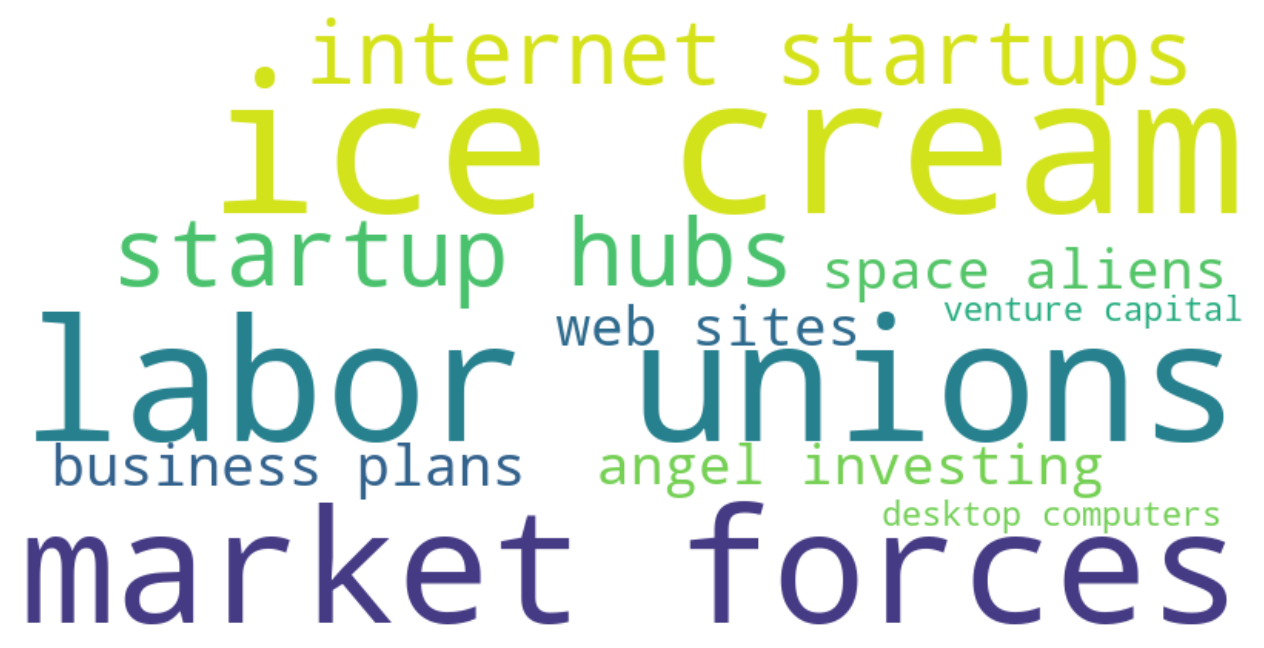

In [13]:
top_noun_phrases = noun_phrase_freq.select("noun_phrases", "count").collect()[39:50]

word_freq_dict = {row["noun_phrases"]: row["count"] for row in top_noun_phrases}

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5), dpi = 160)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()